In [13]:
import os
import pandas as pd
import numpy as np
import random
from scipy.signal import savgol_filter
from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
#from ipywidgets import interact, interactive, widgets, fixed, Layout

#from google.colab import drive
#import tensorflow as tf

%matplotlib inline

In [14]:
#Installation of pybaselines
#!pip install pybaselines
import pybaselines.morphological as pymorph
import pybaselines.whittaker as pywh
import pybaselines.spline as pyspline
import pybaselines.smooth as pysmooth
import pybaselines.polynomial as pypoly

In [15]:
#Cropping Data
def crop_file(f, shift_lim):
    cropped_f = f[f[0]>=shift_lim[0]]
    cropped_f = cropped_f[cropped_f[0]<=shift_lim[1]]
    return cropped_f

In [16]:
#Smoothing Data
from scipy.signal import savgol_filter

def sg_filter(y, order, window):
    index_y =  y.index
    line = y[0]
    y = np.array(y[1])
    z = savgol_filter(y,window,order)
    z = pd.DataFrame(z,index = index_y, columns = [1] )
    z = pd.concat([line, z],axis =1,ignore_index = False)
    return z

In [17]:
#Smoothing Data 2
def whittaker_smoother_df(y, lambda_whittaker, degree_whittaker):
    """Smooth data according to Whittaker.
    
    Parameters
    ----------
    y : pandas dataframe
        [0] = raman_shift 
        [1] = intensity to be smoothed
    lambda_whittaker : float
        smoothing parameter lambda
    degree_whittaker : int
        order of the penalty
    
    Returns
    -------
    z : pandas Dataframe
        [0] raman shift
        [1] smoothed intensity
        
    References
    ----------
    Eilers, P.H., 2003. A perfect smoother. Analytical chemistry, 75(14), pp.3631-3636.
    """   
    index_y =  y.index
    line = y[0]
    y = np.array(y[1])
    m = len(y)
    
    E = np.eye(m)
    D = np.diff(E, degree_whittaker)
    z = np.linalg.solve((E + lambda_whittaker*np.dot(D, D.T)),y)
    z = pd.DataFrame(z,index = index_y , columns = [1])
    z = pd.concat([line, z],axis =1,ignore_index = False)

    return z

In [18]:
#Baseline Correction

def improved_asls(y,lambda_ias,penalty_ias,lambdaDer1_ias,max_iter_ias=50):
    """Perform baseline correction of data by applying an improve asymmetrical least squares (iasls) 
        for baseline fiiting using the iasls function from the pybaseline package

    Parameters
    ----------
    y : pandas dataframe
        [0] = raman_shift 
        [1] = intensity with baseline to be removed
    lambda_ias : float
        The smoothing parameter, Larger values will create smoother baselines.
    penalty_ias : 
        The penalizing weighting factor. Must be between 0 and 1.
    lambdaDer1_ias :
        The smoothing parameter for the first derivative of the residual
    max_iter_ias :
        The max number of fit iterations. Default is 50.
    Returns
    -------
    y : pandas dataframe
        [0] = raman_shift 
        [1] = intensity without baseline
    
    References
    ----------
    Martyna et al. 2020. Improving discrimation of Raman spectra by optimising 
        preprocessing strategies of the basis of the ability to refine the 
        relationship between variance components

    pybaseline package litterature : https://pybaselines.readthedocs.io/
    """
    index_y =  y.index
    line = y[0]
    data = y[1]
    x = np.array(y[1])
    ba, param = pywh.iasls(x,lam=lambda_ias,p=penalty_ias,lam_1=lambdaDer1_ias,max_iter=max_iter_ias)
    z = data-ba
    z = pd.DataFrame(z,index = index_y, columns = [1])
    z = pd.concat([line, z],axis =1,ignore_index = False)
    return z

In [19]:
#Read from TXT file
def Read_Two_Column_File(file_name):
    with open(file_name, 'r') as data:
        x = []
        y = []
        for line in data:
            p = line.split()
            x.append(float(p[0]))
            y.append(float(p[1]))

    return x, y

In [20]:
namefile = '150823-syif-tnt-1M-onSputterCD-5s5x10__04.txt'
x, y = Read_Two_Column_File(namefile)

y = pd.DataFrame (y)
x = pd.DataFrame (x)
maks = y.max()
#y = y/maks
f = pd.concat([x, y], axis=1, ignore_index=True)

print(f)
shift_lim = [400, 1800]
cropped_files = crop_file(f, shift_lim)

              0        1
0     3528.5100  1062.25
1     3527.2300  1067.75
2     3525.9500  1080.00
3     3524.6700  1062.00
4     3523.3900  1065.50
...         ...      ...
2043    93.5869  3745.75
2044    91.4392  3229.50
2045    89.2919  2801.00
2046    87.1447  2383.00
2047    84.9959  2017.00

[2048 rows x 2 columns]


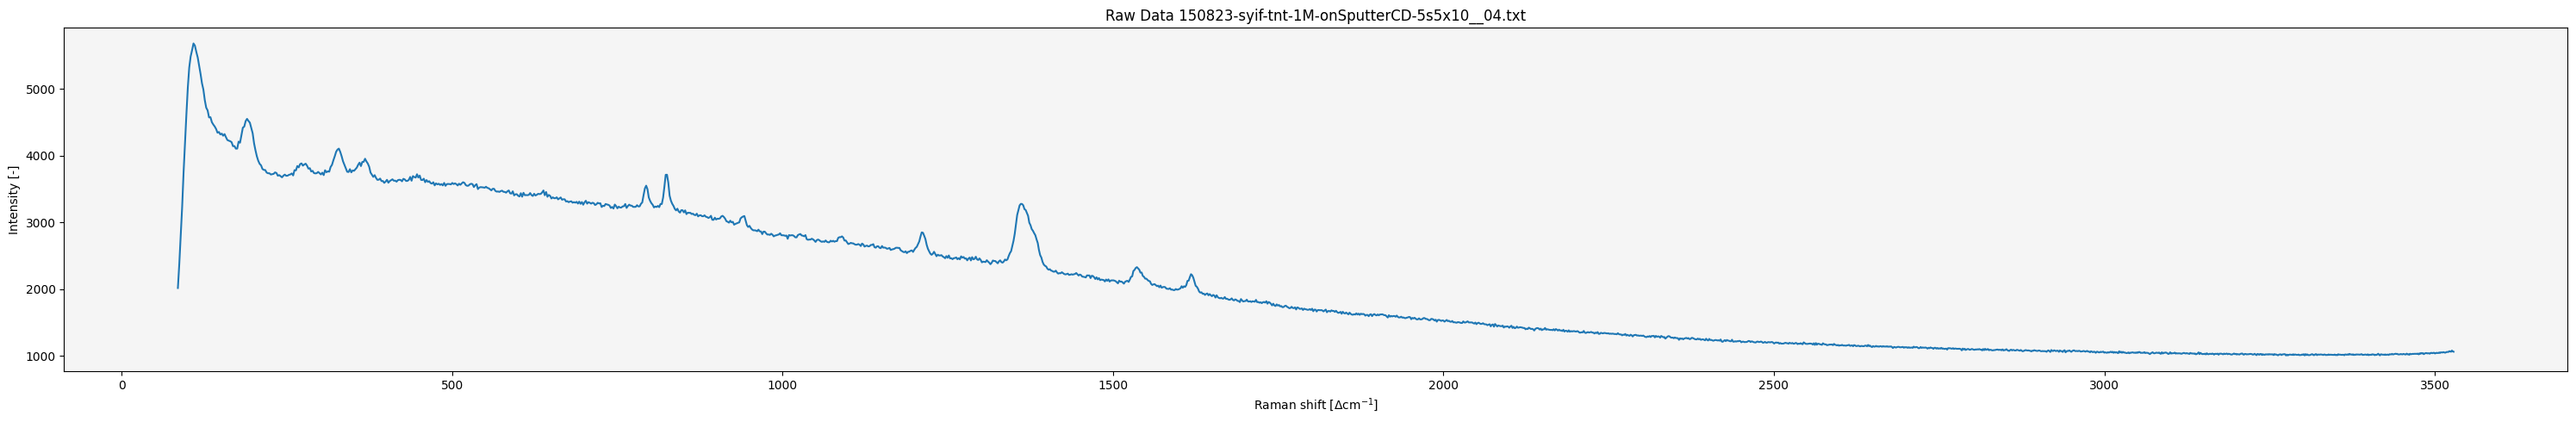

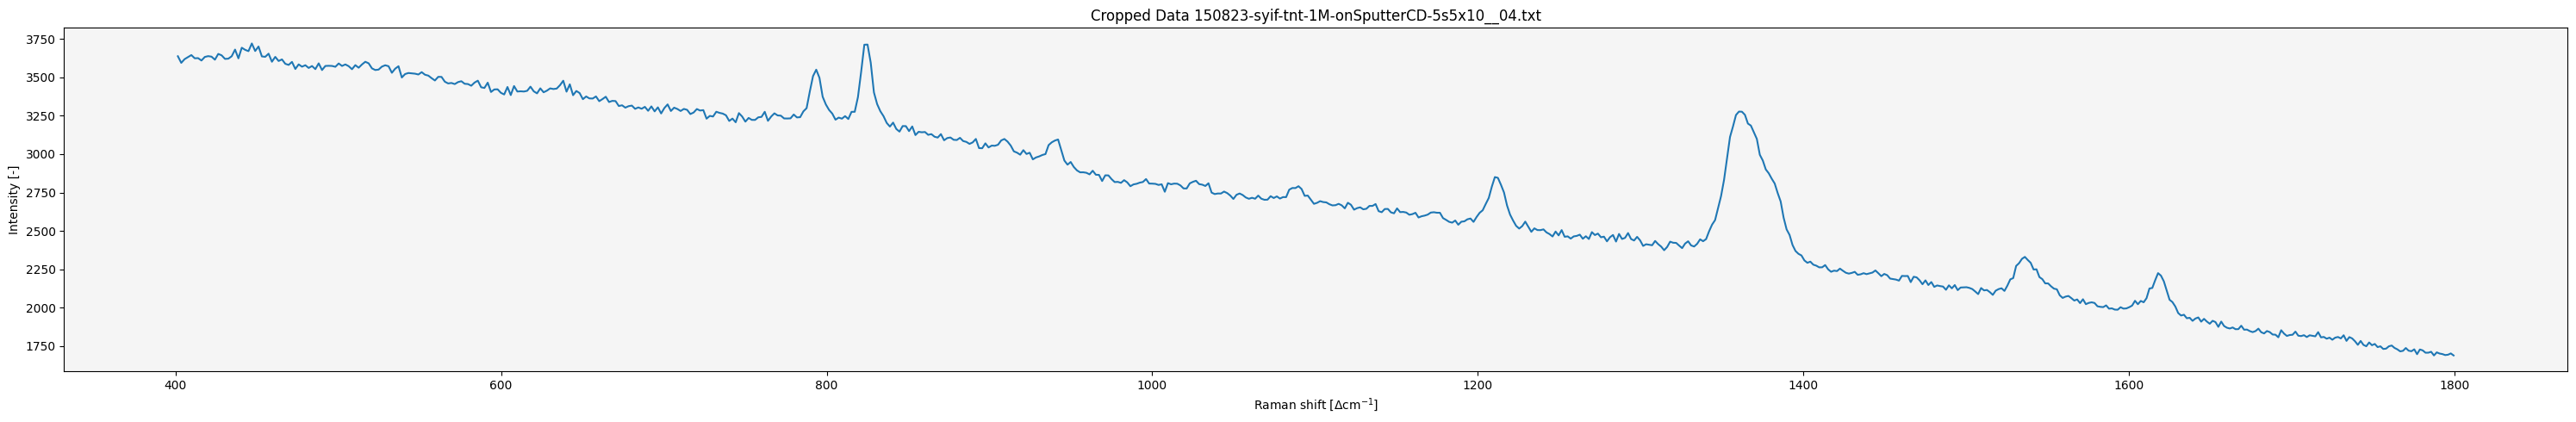

In [21]:
raw_fig, raw_ax = plt.subplots()
raw_ax.plot(f[0], f[1])
raw_ax.set_xlabel("Raman shift [$\Delta$cm$^{-1}$]")
raw_ax.set_ylabel("Intensity [-]")
raw_ax.set_facecolor("whitesmoke")
raw_ax.set_title("Raw Data " + namefile)
plt.tight_layout()


maks = cropped_files[1].max()
#cropped_files[1] = cropped_files[1]/maks
crop_fig, crop_ax = plt.subplots()
crop_ax.plot(cropped_files[0], cropped_files[1])
crop_ax.set_xlabel("Raman shift [$\Delta$cm$^{-1}$]")
crop_ax.set_ylabel("Intensity [-]")
crop_ax.set_facecolor("whitesmoke")
crop_ax.set_title("Cropped Data " + namefile)
plt.tight_layout()

plt.tight_layout()

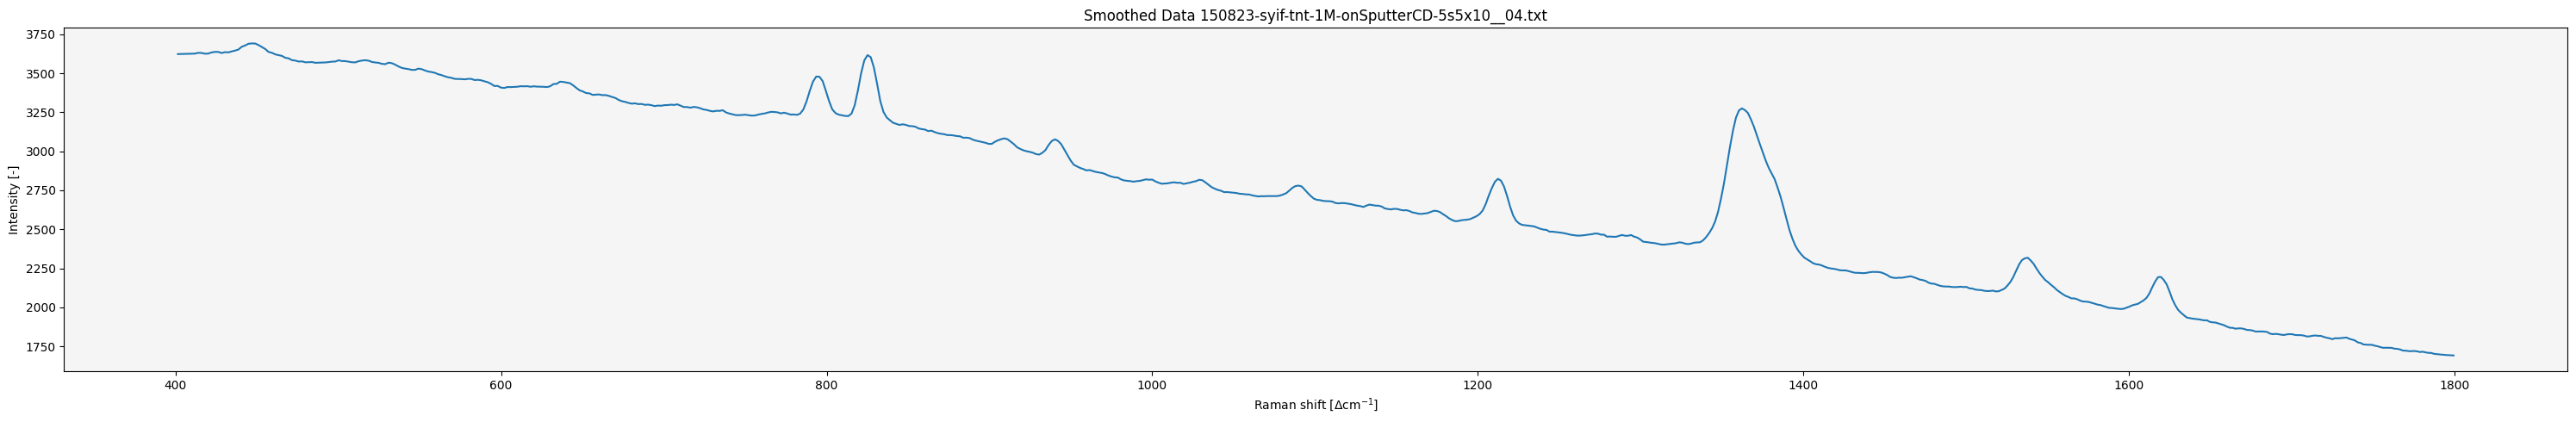

In [22]:
sg_degree = 2
sg_window = 10
smoothed_data = sg_filter(cropped_files,sg_degree,sg_window)

smooth_fig, smooth_ax = plt.subplots()
smooth_ax.plot(smoothed_data[0], smoothed_data[1])
smooth_ax.set_xlabel("Raman shift [$\Delta$cm$^{-1}$]")
smooth_ax.set_ylabel("Intensity [-]")
smooth_ax.set_facecolor("whitesmoke")
smooth_ax.set_title("Smoothed Data " + namefile)
plt.tight_layout()

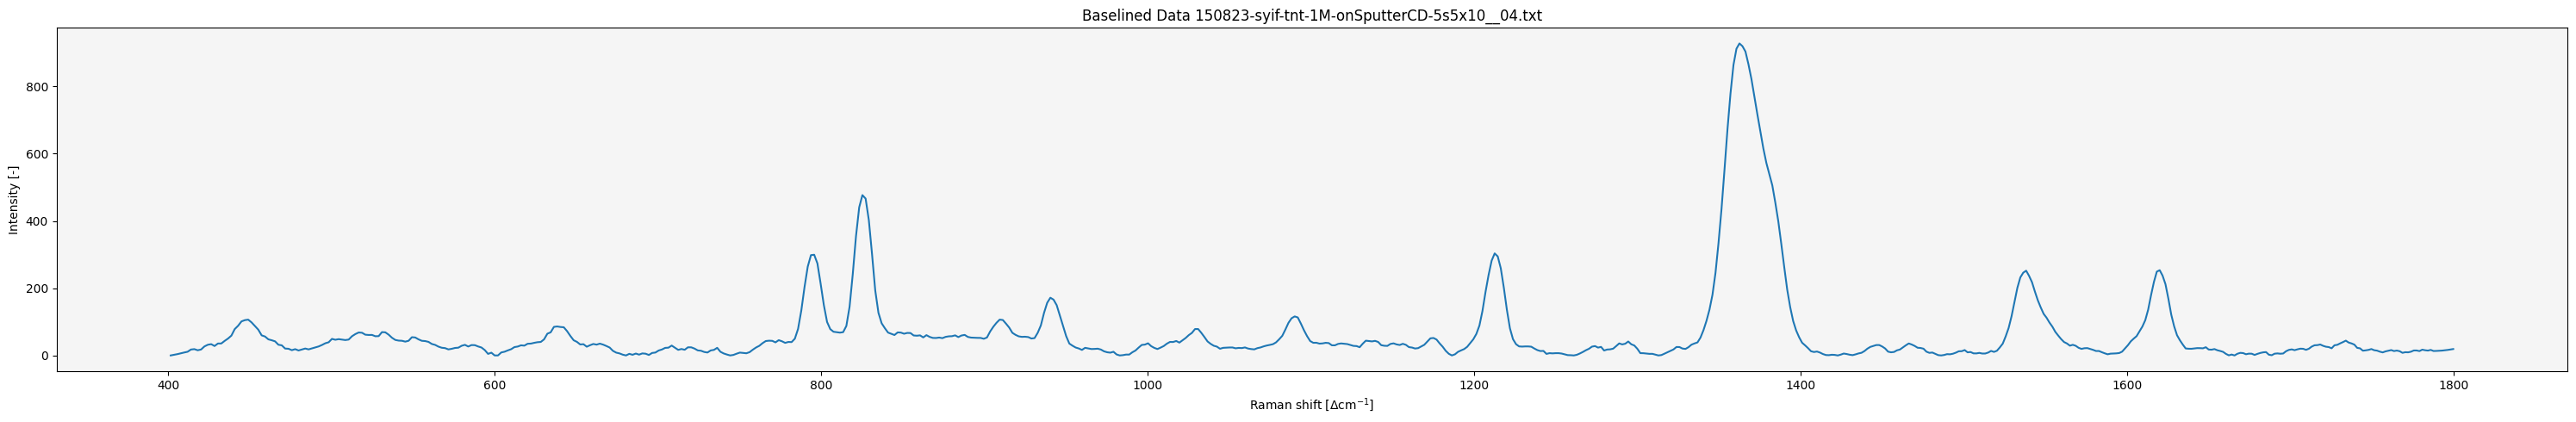

In [23]:
processed_fig, processed_ax = plt.subplots()
lambda_smoother = 0
d_smoother = 0

lambda_ias = 10
penalty_ias = 2e-3
lambda_der1 = 1e-4

s_f = whittaker_smoother_df(smoothed_data, lambda_smoother, d_smoother)
b_f = improved_asls(s_f, lambda_ias, penalty_ias, lambda_der1)
processed_ax.plot(smoothed_data[0], b_f[1])
processed_ax.set_xlabel("Raman shift [$\Delta$cm$^{-1}$]")
processed_ax.set_ylabel("Intensity [-]")
processed_ax.set_facecolor("whitesmoke")
processed_ax.set_title("Baselined Data " + namefile)
plt.rcParams['figure.figsize'] = [30,5]
plt.tight_layout()

In [24]:
bf_df = pd.DataFrame(b_f)
bf_df = bf_df.to_string(header=False, index=False)

# Save PLS components as a new TXT file
with open('readme.txt', 'w') as testxt:
    testxt.write(bf_df)